In [135]:
from __future__ import print_function
from dolfin import *
import numpy as np

In [136]:
# Partim de l'equació de Navier-Stokes escalada: \delta u / \delta t + Re · u · \nabla u = - \nabla u + \nabla ^2 u
# i de \nabla · u = 0

# u = (ux,0) --> \delta u /\delta x = 0 , per tant ux=ux(y)

# Aplicant això obtenim que p(x) = 8(1-x) i ux=4y(1-y)




In [137]:
# Variables:

T = 10.0           # temps total
num_steps = 500    # nombre de time steps
dt = T / num_steps # dt
mu = 1             # viscositat
rho = 1            # densitat

In [138]:
# Create mesh and define function spaces
n_1=5
n_2=10
n_3=20
n_4=40
N=10
mesh = UnitSquareMesh(N, N)
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió

In [139]:
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

In [140]:
# Definim els contorns

inflow  = 'near(x[0], 0)' 
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'

In [141]:
# Define boundary conditions
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow) # quan x=0 p=8
bcp_outflow = DirichletBC(Q, Constant(0), outflow) # quan x=1 p=0
bcu = [bcu_noslip] 
bcp = [bcp_inflow, bcp_outflow]

In [142]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [143]:
# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)


In [144]:
# Define expressions used in variational forms
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)

In [145]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

In [146]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx



In [147]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None, None]

In [148]:
import matplotlib.pyplot as plt

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)






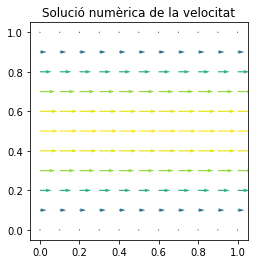

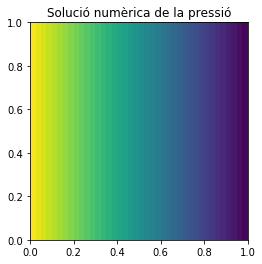

In [149]:
# Plot solution    
plot(u_)
plt.title('Solució numèrica de la velocitat')
plt.show()

plot(p_)
plt.title('Solució numèrica de la pressió')
plt.show()

In [150]:
# Guardem la solució
file = File("channel_flow_matriu_valors.pvd")
file << u_

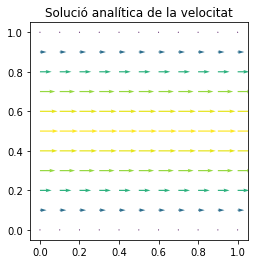

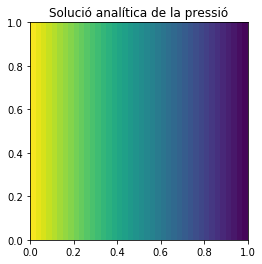

In [151]:
# Plot de la solució analítica
u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
u_a = interpolate(u_a, V)
plot(u_a)
plt.title('Solució analítica de la velocitat')
plt.show()

p_a = Expression(("8*(1-x[0])"),degree=1)
Q2 = FunctionSpace(mesh, "Lagrange", 1)  
p_a_Q= interpolate(p_a,Q2) 
plot(p_a_Q)
plt.title('Solució analítica de la pressió') 
plt.show()


In [152]:
# Error per la velocitat A L'ESPAI DE FUNCIONS

print('Per la velocitat:')
#Error màxim
e_max = np.abs(u_a.vector().get_local() - u_.vector().get_local()).max()
#Error global
error = (u_-u_a)**2*dx #error a cada punt de l'àrea
e_mitj = sqrt(assemble(error))

print('error màxim = %.3g' % (e_max))
print('error global= %.3g' % (e_mitj))

# Error per la pressió
print('Per la pressió:')
p_Q2=interpolate(p_,Q2)
#Error màxim
e_max = np.abs(p_a_Q.vector().get_local() - p_Q2.vector().get_local()).max()
#Error global
error = (p_-p_a_Q)**2*dx #error a cada punt de l'àrea
e_mitj = sqrt(assemble(error))

print('error màxim = %.3g' % (e_max))
print('error global= %.3g' % (e_mitj))


Per la velocitat:
error màxim = 3.41e-07
error global= 5.79e-08
Per la pressió:
error màxim = 1.5e-07
error global= 1.31e-08


In [153]:
eix_y = np.linspace(0, 1, N+1)
eix_x = np.linspace(0,1,N+1) 
e0 = [0,0,0]
u_y=[]
ey=[]
for i,x in enumerate(eix_x):
  exy = []
  for j,y in enumerate(eix_y):
    u_y.append(e0)
    u_y[j] = u_(x,y)
    modul = np.linalg.norm(u_y[j])
    a = modul - u_a(x,y)
    ey.append(a)
  exy.append(ey)
e_max=np.amax(exy)
e_mitj=np.median(exy)
e_1=e_max
E_1=e_mitj
print(f"Error màxim : {e_max:.2e}")
print(f"Error mitjà : {e_mitj:.2e}")

Error màxim : 1.00e+00
Error mitjà : 1.12e-09


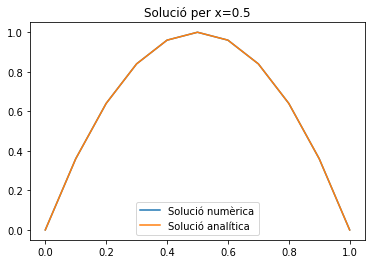

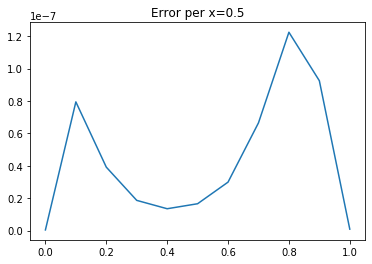

In [154]:
# Ara voldrem representar les funcions en 1 dimensió avaluant-les en x=0.5.

# Funció numèrica
eix_y = np.linspace(0, 1, N+1)
e0 = [0,0,0]
u_x_05=[]

for i, y in enumerate(eix_y):
    u_x_05.append(e0)
    u_x_05[i] = u_(0.5,y)

u_x_05_m = []
for i, y in enumerate(eix_y):
    modul = np.linalg.norm(u_x_05[i])
    u_x_05_m.append(modul)

    
plt.plot(eix_x, u_x_05_m, label= 'Solució numèrica')
plt.legend()
plt.title("Solució per x=0.5")




# Solució analítica
u_a_x_05 = []
for i, y in enumerate(eix_y):
    ua = 4*y*(1.0 - y)
    u_a_x_05.append(ua)
    
plt.plot(eix_y, u_a_x_05, label= 'Solució analítica')
plt.legend()
plt.title("Solució per x=0.5")

plt.show()
# Representem ara la diferència entre les dos funcions

error_05 = []
for i, y in enumerate(eix_y):
    e = np.abs(u_a_x_05[i]-u_x_05_m[i] )
    error_05.append(e)
plt.plot(eix_y, error_05)
plt.title("Error per x=0.5")

plt.show()


In [155]:
N=n_2
mesh = UnitSquareMesh(N, N)
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
inflow  = 'near(x[0], 0)' 
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow) # quan x=0 p=8
bcp_outflow = DirichletBC(Q, Constant(0), outflow) # quan x=1 p=0
bcu = [bcu_noslip] 
bcp = [bcp_inflow, bcp_outflow]
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
eix_y = np.linspace(0, 1, N+1)
eix_x = np.linspace(0,1,N+1)
for i,x in enumerate(eix_x):
  exy = []
  for j,y in enumerate(eix_y):
    u_y.append(e0)
    u_y[j] = u_(x,y)
    modul = np.linalg.norm(u_y[j])
    a = modul - u_a(x,y)
    ey.append(a)
  exy.append(ey)
e_max=np.amax(exy)
e_mitj=np.median(exy)
e_2=e_max
E_2=e_mitj

In [156]:
N=n_3
mesh = UnitSquareMesh(N, N)
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
inflow  = 'near(x[0], 0)' 
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow) # quan x=0 p=8
bcp_outflow = DirichletBC(Q, Constant(0), outflow) # quan x=1 p=0
bcu = [bcu_noslip] 
bcp = [bcp_inflow, bcp_outflow]
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
eix_y = np.linspace(0, 1, N+1)
eix_x = np.linspace(0,1,N+1)
for i,x in enumerate(eix_x):
  exy = []
  for j,y in enumerate(eix_y):
    u_y.append(e0)
    u_y[j] = u_(x,y)
    modul = np.linalg.norm(u_y[j])
    a = modul - u_a(x,y)
    ey.append(a)
  exy.append(ey)
e_max=np.amax(exy)
e_mitj=np.median(exy)
e_3=e_max
E_3=e_mitj

In [157]:
N=n_4
mesh = UnitSquareMesh(N, N)
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
inflow  = 'near(x[0], 0)' 
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow) # quan x=0 p=8
bcp_outflow = DirichletBC(Q, Constant(0), outflow) # quan x=1 p=0
bcu = [bcu_noslip] 
bcp = [bcp_inflow, bcp_outflow]
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
eix_y = np.linspace(0, 1, N+1)
eix_x = np.linspace(0,1,N+1)
for i,x in enumerate(eix_x):
  exy = []
  for j,y in enumerate(eix_y):
    u_y.append(e0)
    u_y[j] = u_(x,y)
    modul = np.linalg.norm(u_y[j])
    a = modul - u_a(x,y)
    ey.append(a)
  exy.append(ey)
e_max=np.amax(exy)
e_mitj=np.median(exy)
e_4=e_max
E_4=e_mitj

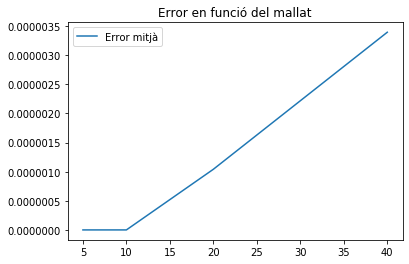

In [158]:
N=[n_1,n_2,n_3,n_4]
e_max_1=[e_1,e_2,e_3,e_4] #llista dels diferents errors màxims en funció de les divisions de la quadrícula
#plt.plot(N,e_max_1,label='Error màxim')
plt.title("Error en funció del mallat")
e_mitj_1=[E_1,E_2,E_3,E_4] #llista dels diferents errors màxims en funció de les divisions de la quadrícula
plt.plot(N,e_mitj_1,label='Error mitjà')
plt.legend()
plt.show()

In [126]:
# Provem ara quina és la influència del dt en l'error
# _____________________________________________________________________________________________________________________________
# dt=1

T = 10.0           # temps total
num_steps = 100    # nombre de time steps
dt = T / num_steps # dt
dt1=dt
k   = Constant(dt)
N=n_2
mesh = UnitSquareMesh(N, N)
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
inflow  = 'near(x[0], 0)' 
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow) # quan x=0 p=8
bcp_outflow = DirichletBC(Q, Constant(0), outflow) # quan x=1 p=0
bcu = [bcu_noslip] 
bcp = [bcp_inflow, bcp_outflow]
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    
for i,x in enumerate(eix_x):
  exy = []
  for j,y in enumerate(eix_y):
    u_y.append(e0)
    u_y[j] = u_(x,y)
    modul = np.linalg.norm(u_y[j])
    a = modul - u_a(x,y)
    ey.append(a)
  exy.append(ey)
e_max=np.amax(exy)
e_mitj=np.median(exy)
e_1=e_max
E_1=e_mitj

# _____________________________________________________________________________________________________________________________
# dt=0.1

T = 10.0           # temps total
num_steps = 100    # nombre de time steps
dt = T / num_steps
dt2=dt 
k   = Constant(dt)
N=n_2
mesh = UnitSquareMesh(N, N)
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
inflow  = 'near(x[0], 0)' 
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow) # quan x=0 p=8
bcp_outflow = DirichletBC(Q, Constant(0), outflow) # quan x=1 p=0
bcu = [bcu_noslip] 
bcp = [bcp_inflow, bcp_outflow]
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
eix_y = np.linspace(0, 1, N+1)
eix_x = np.linspace(0,1,N+1)
for i,x in enumerate(eix_x):
  exy = []
  for j,y in enumerate(eix_y):
    u_y.append(e0)
    u_y[j] = u_(x,y)
    modul = np.linalg.norm(u_y[j])
    a = modul - u_a(x,y)
    ey.append(a)
  exy.append(ey)
e_max=np.amax(exy)
e_mitj=np.median(exy)
e_1=e_max
E_1=e_mitj

# _____________________________________________________________________________________________________________________________
# dt=0.05

T = 10.0           # temps total
num_steps = 200    # nombre de time steps
dt = T / num_steps # dt
k   = Constant(dt)
N=n_2
mesh = UnitSquareMesh(N, N)
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
inflow  = 'near(x[0], 0)' 
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow) # quan x=0 p=8
bcp_outflow = DirichletBC(Q, Constant(0), outflow) # quan x=1 p=0
bcu = [bcu_noslip] 
bcp = [bcp_inflow, bcp_outflow]
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
eix_y = np.linspace(0, 1, N+1)
eix_x = np.linspace(0,1,N+1)    
for i,x in enumerate(eix_x):
  exy = []
  for j,y in enumerate(eix_y):
    u_y.append(e0)
    u_y[j] = u_(x,y)
    modul = np.linalg.norm(u_y[j])
    a = modul - u_a(x,y)
    ey.append(a)
  exy.append(ey)
e_max=np.amax(exy)
e_mitj=np.median(exy)
e_2=e_max
E_2=e_mitj

# _____________________________________________________________________________________________________________________________
# dt=0.02

T = 10.0           # temps total
num_steps = 500    # nombre de time steps
dt = T / num_steps # dt
dt3=dt
k   = Constant(dt)
N=n_2
mesh = UnitSquareMesh(N, N)
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
inflow  = 'near(x[0], 0)' 
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow) # quan x=0 p=8
bcp_outflow = DirichletBC(Q, Constant(0), outflow) # quan x=1 p=0
bcu = [bcu_noslip] 
bcp = [bcp_inflow, bcp_outflow]
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
eix_y = np.linspace(0, 1, N+1)
eix_x = np.linspace(0,1,N+1)    
for i,x in enumerate(eix_x):
  exy = []
  for j,y in enumerate(eix_y):
    u_y.append(e0)
    u_y[j] = u_(x,y)
    modul = np.linalg.norm(u_y[j])
    a = modul - u_a(x,y)
    ey.append(a)
  exy.append(ey)
e_max=np.amax(exy)
e_mitj=np.median(exy)
e_3=e_max
E_3=e_mitj
# _____________________________________________________________________________________________________________________________
# dt=0.01

T = 10.0           # temps total
num_steps = 1000    # nombre de time steps
dt = T / num_steps # dt
dt4=dt
k   = Constant(dt)

t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    u_a = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_a = interpolate(u_a, V)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
eix_y = np.linspace(0, 1, N+1)
eix_x = np.linspace(0,1,N+1)
for i,x in enumerate(eix_x):
  exy = []
  for j,y in enumerate(eix_y):
    u_y.append(e0)
    u_y[j] = u_(x,y)
    modul = np.linalg.norm(u_y[j])
    a = modul - u_a(x,y)
    ey.append(a)
  exy.append(ey)
e_max=np.amax(exy)
e_mitj=np.median(exy)
e_4=e_max
E_4=e_mitj


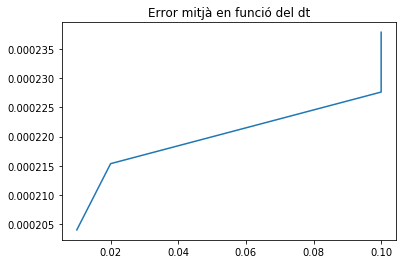

In [131]:
N=[dt1,dt2,dt3,dt4]
e_max_dt=[e_1,e_2,e_3,e_4] #llista dels diferents errors màxims en funció de les divisions de la quadrícula
#plt.plot(N,e_max_dt,label='Error màxim')
e_mitj_dt=[E_1,E_2,E_3,E_4] #llista dels diferents errors màxims en funció de les divisions de la quadrícula
plt.plot(N,e_mitj_dt)
plt.title("Error mitjà en funció del dt")
plt.show()